# Predicting Stroke
Author: Necky Tran <br>
Date: 06/06/23

### Table of Contents

1. [Introduction](#Introduction)
2. [Wrangling](#Wrangling)
3. [Statistical Analysis](#Statistical_Analysis)
4. [Logistic Regression](#Logistic)
5. [Summary](#Summary)

# Introduction
This notebook contains an analysis of a of a US Health Insurance Dataset. The dataset is sourced from Kaggle:
- 'https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset'

The dataset was cleaned and analyzed to generate a logistic model to predict likelyhood of stroke.

In [1]:
# load standard packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# read in and check data
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


The data has been successfully loaded


# Wrangling
- Exploratory Data Analysis
    - Find which columns need to be converted into numeric
    - Deal with NaNs and Duplicates

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


There are 5110 rows and 12 columns

The [bmi] column has some missing values, we can explore this further 

In [4]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [5]:
# Check which columns have NaN values
#.isna() returns a dataframe of T/F for any element that is missing
#.any() tells us if there are any Trues in that column
df.isna().any()

id                   False
gender               False
age                  False
hypertension         False
heart_disease        False
ever_married         False
work_type            False
Residence_type       False
avg_glucose_level    False
bmi                   True
smoking_status       False
stroke               False
dtype: bool

In [6]:
df.isna().mean()*100

id                   0.000000
gender               0.000000
age                  0.000000
hypertension         0.000000
heart_disease        0.000000
ever_married         0.000000
work_type            0.000000
Residence_type       0.000000
avg_glucose_level    0.000000
bmi                  3.933464
smoking_status       0.000000
stroke               0.000000
dtype: float64

The BMI column has some NAs, about 4% of the total data. Explore futher to make a decision one whether to drop or impute <br>

In [7]:
# find rows of data where bmi is missing
df[df['bmi'].isna()]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
13,8213,Male,78.0,0,1,Yes,Private,Urban,219.84,NaN,Unknown,1
19,25226,Male,57.0,0,1,No,Govt_job,Urban,217.08,NaN,Unknown,1
27,61843,Male,58.0,0,0,Yes,Private,Rural,189.84,NaN,Unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5039,42007,Male,41.0,0,0,No,Private,Rural,70.15,NaN,formerly smoked,0
5048,28788,Male,40.0,0,0,Yes,Private,Urban,191.15,NaN,smokes,0
5093,32235,Female,45.0,1,0,Yes,Govt_job,Rural,95.02,NaN,smokes,0
5099,7293,Male,40.0,0,0,Yes,Private,Rural,83.94,NaN,smokes,0


There are 201 rows where the bmi value is missing

In [8]:
# explore missing data, 
df[df['bmi'].isna()].describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,201.000000,201.000000,201.000000,201.000000,201.000000,0.0,201.000000
mean,23171.109453,52.049154,0.233831,0.164179,126.724627,NaN,0.199005
std,20882.483120,22.276181,0.424323,0.371363,59.240322,NaN,0.400249
min,67.000000,0.480000,0.000000,0.000000,57.520000,NaN,0.000000
25%,4062.000000,37.000000,0.000000,0.000000,81.430000,NaN,0.000000
50%,18234.000000,58.000000,0.000000,0.000000,99.870000,NaN,0.000000
75%,37937.000000,71.000000,0.000000,0.000000,191.790000,NaN,0.000000
max,72231.000000,82.000000,1.000000,1.000000,260.850000,NaN,1.000000


 28.89 is the mean BMI
 28.1 is the median BMI


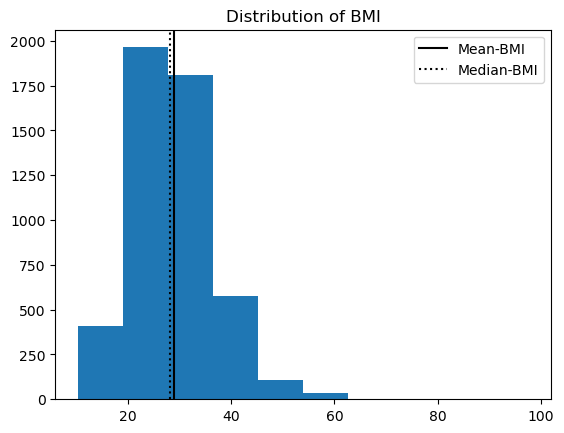

In [20]:
# histogram of two categories
plt.hist(df['bmi'])
plt.axvline(df['bmi'].mean(),linestyle = 'solid',label = "Mean-BMI", color = 'black')
plt.axvline(df['bmi'].median(),linestyle = 'dotted',label = "Median-BMI", color = 'black')
plt.title('Distribution of BMI')
plt.legend(loc='upper right');


print(f" {round(df['bmi'].mean(), 2)} is the mean BMI")

print(f" {df['bmi'].median()} is the median BMI")

The mean and median BMI are very similar which means this data is symetrically distributed around a central value. There are no extreme outliers pulling the mean away from the median. It would be appropriate to use a mean imputation on the missing data.

In [9]:
df.duplicated().sum()

0

There are no duplicated Rows in the Dataset

In [21]:
df['bmi'] = np.where(df['bmi'].isna(), 28, df['bmi'])

In [23]:
df['bmi'].isna().sum()

0

In [24]:
df[df['bmi'].isna()]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
